In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from mplsoccer import Pitch, VerticalPitch
from highlight_text import ax_text


import json 
from itertools import chain
import seaborn as sn
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
from scipy import optimize as op
from scipy.spatial import ConvexHull

hfont = {'fontname':'Georgia'}



In [2]:

match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039] 

folder_path = os.path.join(os.getcwd(), 'corners')

#for increasing number of samples - all the corners that the home team in every games takes are assumed to be *conceded* by the OPPONENT
# & all the corners that the away team in every games takes are assumed to be *taken by* the OPPONENT
def read_csv_files(id_list):
    defensive_files = []
    offensive_files = []

    for id in id_list:
        defensive_files.extend(glob.glob(os.path.join(folder_path, f"{id}_home_*.csv")))
        offensive_files.extend(glob.glob(os.path.join(folder_path, f"{id}_away_*.csv")))

    defense_data = []
    for file in defensive_files:
        data = pd.read_csv(file)
        defense_data.append(data)

    offense_data = []
    for file in offensive_files:
        data = pd.read_csv(file)
        offense_data.append(data)


    return defense_data, offense_data, defensive_files, offensive_files

defensive_list, offensive_list, defensive_files, offensive_files = read_csv_files(match_ids)



Find the closest corner to the ball position. Just keeping one of the if/else checks should be sufficient as well.

In [3]:
def get_closest_corner(dataframe, defensive_flag):

    x, y = dataframe.iloc[0][["ball_x","ball_y"]].values
    
    if defensive_flag:

        distances = [
            math.sqrt((x - 105)**2 + y**2),    # Distance to (105, 0)
            math.sqrt((x - 105)**2 + (y - 68)**2)  # Distance to (105, 68)
        ]

    else:
        distances = [
            
            math.sqrt(x**2 + (y - 68)**2),     # Distance to (0, 68)
            math.sqrt(x**2 + y**2)             # Distance to (0, 0)
        ]


    #flags - if you are facing towards either side goals - 1 is the corner towards your left , 2 towards your right
    closest_flag = distances.index(min(distances)) + 1
    return closest_flag


For the opposition team - how many corner situations they have had from each side - for/against 

In [4]:
attacking_corner_counter = {}
defensive_corner_counter = {}
attacking_corner_directions = []
defensive_corner_directions = []

def corner_and_direction_count(corner_list, defensive_flag):

    corner_counter = {}
    corner_directions = []

    for corners in corner_list:

        direction = get_closest_corner(corners, defensive_flag)
        corner_directions.append(direction)
        
        if direction == 1:
            corner_counter['from_left'] = corner_counter.get('from_left', 0) + 1
        
        else:
            corner_counter['from_right'] = corner_counter.get('from_right', 0) + 1

    return corner_counter, corner_directions


attacking_corner_counter, attacking_corner_directions = corner_and_direction_count(offensive_list, False)
defensive_corner_counter, defensive_corner_directions = corner_and_direction_count(defensive_list, True)

print("Corners taken by the opponent: ", attacking_corner_counter)
print("Corners conceded by the opponent", defensive_corner_counter)

Corners taken by the opponent:  {'from_left': 14, 'from_right': 7}
Corners conceded by the opponent {'from_left': 6, 'from_right': 9}


In [5]:
def get_goalkeeper(matchdata):

    home_team_id = matchdata['home_team']['id']
    away_team_id = matchdata['away_team']['id']

    home_gk = None
    away_gk = None
    
    for player in matchdata['players']:
        if (player['player_role']['name'] == "Goalkeeper") and (player["start_time"] == "00:00:00"):
            
            if player['team_id'] == home_team_id:
                home_gk = ("home_" + str(player['number']))
            
            else:
                away_gk = ("away_" + str(player['number']))
        
    return home_gk, away_gk


def find_corner_takers(corner_list,files_list,home_flag, path_to_files):

    players = {}
    corner_directions = {'from_left' : {}, 'from_right' : {}}
    goal_keepers = []
    total_corners = 0

    if home_flag:
        search_string = "_home"

    else:
        search_string = "_away"

    for i in range(len(files_list)):
        id = files_list[i].split(search_string)[0].split("\\")[-1]

        tracking_file = os.path.join(path_to_files, str(id) + '\\structured_data.json')
        matchdata_file = os.path.join(path_to_files, str(id) + '\\match_data.json')

        tf = open(tracking_file)
        tracking_data = json.load(tf) 

        mf = open(matchdata_file)
        matchdata = json.load(mf) 

        if home_flag:
            _, away_gk =  get_goalkeeper(matchdata)

            direction = get_closest_corner(corner_list[i], home_flag)
            
            goal_keepers.append(away_gk)

        else:
            home_gk, _ = get_goalkeeper(matchdata)
            direction = get_closest_corner(corner_list[i], home_flag)
            goal_keepers.append(home_gk)

        total_corners+=1

        #find player tracked closest to the corner arc
        player_trackable_id = tracking_data[corner_list[i].iloc[0]['frame_id']]['possession']['trackable_object']
        
        
        for player in matchdata['players']:
            if player['trackable_object'] == player_trackable_id:
                
                player_name = player['first_name'] + " " + player['last_name']
                players[player_name] = players.get(player_name, 0) + 1

                if direction == 1:
                    corner_directions['from_left'][player_name] = corner_directions['from_left'].get(player_name, 0) + 1

                else:
                    corner_directions['from_right'][player_name] = corner_directions['from_right'].get(player_name, 0) + 1


    return players, goal_keepers, corner_directions, total_corners

Currently not an efficient search - takes about 40 seconds or so. Can be made faster by storing player trackable_object separately, rather than acccessing the tracking data every time.

In [6]:
file_path = 'C:\\Users\\mishr\\Desktop\\fbref\\tracking data\\opendata-master\\data\\matches'

self_corner_takers, gk_for_ac, self_corner_directions, total_corners_conceded = find_corner_takers(defensive_list,defensive_files,True, file_path)
print("Total corners taken against opposition: ", total_corners_conceded)
print("Corner takers against opposition: ", self_corner_takers)
print("Directions for corner takers against opposition: ", self_corner_directions)


opposition_corner_takers, gk_for_dc, opposition_corner_directions, total_corners_taken = find_corner_takers(offensive_list,offensive_files,False, file_path)
print("Total corners taken by the opposition: ", total_corners_taken)
print("Opposition corner takers: ",opposition_corner_takers)
print("Directions for opposition corner: ", opposition_corner_directions)

Total corners taken against opposition:  15
Corner takers against opposition:  {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}
Directions for corner takers against opposition:  {'from_left': {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}, 'from_right': {}}
Total corners taken by the opposition:  21
Opposition corner takers:  {'Ferland Mendy': 1}
Directions for opposition corner:  {'from_left': {'Ferland Mendy': 1}, 'from_right': {}}


In [7]:
#uncomment the below code to visualize the trajectory of the ball for all corner situations  - currently just shows the 1st corner frame.
# for i in range(len(offensive_list)):

#         pitch = Pitch(pitch_color='grass',pitch_type='custom',
#                 pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

#         fig, ax = pitch.draw(figsize=(14, 12))

#         fig.set_facecolor('#4a8a32')

#         ax.plot( offensive_list[i][['ball_x']].dropna().values, 68 - offensive_list[i][['ball_y']].dropna().values, 'b.', MarkerSize=10, zorder=3)
        

In [8]:
def get_x_y_columns(dataframe, string_search):
    
    x_cols = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_x')]
    y_cols = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_y')]

    x_velocity = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_vx')]
    y_velocity = [col for col in dataframe.columns if col.startswith(string_search) and col.endswith('_vy')]

    return x_cols, y_cols, x_velocity, y_velocity
 

In [9]:
def get_best_frame(list_dataframe, home_team_flag, min_opp_players):

    selected_corner_ids = []

    if home_team_flag:
        final_third_line = 88.5

    else:
        final_third_line = 16.5
    
    list_best_frames = []
    home_columns_list = []
    away_columns_list = []

    home_velocity_columns = []
    away_velocity_columns = []

    max_score_row_index = None

    for i in range(len(list_dataframe)):

        home_x, home_y, home_x_vel, home_y_vel = get_x_y_columns(list_dataframe[i], 'home_')
    
        away_x, away_y, away_x_vel, away_y_vel = get_x_y_columns(list_dataframe[i], 'away_')               

        scores = []

        for _, row in list_dataframe[i].iterrows():
            score = 0
            
            for x_col, y_col in zip(away_x, away_y):
                
                if home_team_flag:
                    if pd.notna(row[x_col]) and pd.notna(row[y_col]) and row[x_col] > final_third_line and 14 <= row[y_col] <= 54:
                        score += 1

                else:
                    if pd.notna(row[x_col]) and pd.notna(row[y_col]) and row[x_col] < final_third_line and 14 <= row[y_col] <= 54:
                        score += 1
            
            scores.append(score)
                
        if max(scores) > min_opp_players:
            
            # Access the row with max. opposition players in the box
            max_score_row_index = max(range(len(scores)), key=scores.__getitem__)

            
            list_best_frames.append(list_dataframe[i].loc[max_score_row_index])
            home_columns_list.append((home_x, home_y))
            away_columns_list.append((away_x, away_y))

            home_velocity_columns.append((home_x_vel, home_y_vel))
            away_velocity_columns.append((away_x_vel, away_y_vel))

            selected_corner_ids.append(i)


    return list_best_frames, home_columns_list, away_columns_list, home_velocity_columns, away_velocity_columns, selected_corner_ids

In [10]:
min_no_of_opposition_players_in_frame = 3

#Attacking Corners - "ac"
#Defending Corner - "dc"

#Columns representing Team's players - "self_cols"
#Columns representing Oppositons's players  - "opp_cols"


opp_best_defensive_frames, self_cols_ac, opp_cols_ac, self_velocity_ac, opp_velocity_ac, defensive_corner_subset  = get_best_frame(defensive_list, True, min_no_of_opposition_players_in_frame)

opp_best_attacking_frames, self_cols_dc, opp_cols_dc, self_velocity_dc, opp_velocity_dc, attacking_corner_subset= get_best_frame(offensive_list, False, min_no_of_opposition_players_in_frame)

In [11]:
def filter_corner_direction_entries(entries, indices):
    filtered_entries = [entry for i, entry in enumerate(entries) if i in indices]
    return filtered_entries


In [12]:
attacking_corner_directions = filter_corner_direction_entries(attacking_corner_directions, attacking_corner_subset)

In [13]:
defensive_corner_directions = filter_corner_direction_entries(defensive_corner_directions, defensive_corner_subset)

In [14]:
#remove opposition goalkeeper while analyzing opposition's defensive shape (for better clustering)

for i in range(len(opp_cols_ac)):

    gk_x, gk_y = gk_for_ac[i]+"_x", gk_for_ac[i]+"_y"
    
    if gk_x in opp_cols_ac[i][0]:
        opp_cols_ac[i][0].remove(gk_x)
    
    if gk_y in opp_cols_ac[i][1]:
        opp_cols_ac[i][1].remove(gk_y)
    

Visualizing the distance between the attackers & opposition defenders

In [15]:
# Idea still to be built upon, these distances could perhaps be used as features to detect zonal/man-marking systems during given corner situations,
# will need removing the corner.

'''
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def euclidean_similarity(array1, array2):
    num_points1 = array1.shape[0]
    num_points2 = array2.shape[0]
    
    cost_matrix = np.zeros((num_points1, num_points2))
    
    for i in range(num_points1):
        for j in range(num_points2):
            cost_matrix[i, j] = euclidean_distance(array1[i], array2[j])
    

    # Perform linear sum assignment and get mean squared distance
    sol_rows, sol_cols = op.linear_sum_assignment(cost_matrix)
    mean_dist = cost_matrix[sol_rows, sol_cols].sum()
    # updated_cost_matrix = cost_matrix[sol_rows, sol_cols]


    return mean_dist, sol_rows, sol_cols
'''


'''
#x and y coordinates of team's players across all frames for defensive corners
self_all_x_ac = []
self_all_y_ac = []

#x and y coordinates of opposition players while they are defending a corner situation
opp_all_x_ac = []
opp_all_y_ac = []

#uncomment the below code to visualize all  - currently just shows the 1st corner frame.
# for i in range(len(opp_best_defensive_frames)):
for i in range(1):
        pitch = Pitch(pitch_color='grass',pitch_type='custom',
                pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

        fig, ax = pitch.draw(figsize=(14, 12))

        fig.set_facecolor('#4a8a32')

        ax.plot( opp_best_defensive_frames[i][self_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][self_cols_dc[i][1]], 'b.', MarkerSize=10, zorder=3)
        
        self_all_x_ac.append(opp_best_defensive_frames[i][self_cols_dc[i][0]].dropna().values)
        self_all_y_ac.append(68 - opp_best_defensive_frames[i][self_cols_dc[i][1]].dropna().values)
         

        ax.plot( opp_best_defensive_frames[i][opp_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][opp_cols_dc[i][1]], 'r.', MarkerSize=10, zorder=3)
        opp_all_x_ac.append(opp_best_defensive_frames[i][opp_cols_dc[i][0]].dropna().values)
        opp_all_y_ac.append(68 - opp_best_defensive_frames[i][opp_cols_dc[i][1]].dropna().values)

        #stacking all the (x,y) points to change shape from 1D array to 2D array.
        attack_coord = np.column_stack((self_all_x_ac[i], self_all_y_ac[i]))
        defence_coord = np.column_stack((opp_all_x_ac[i], opp_all_y_ac[i]))

        #linear assignment problem       
        cost, sol_rows, sol_cols = euclidean_similarity(attack_coord, defence_coord)
        
        
        #overlaps best assignments
        # {
        
        for rows in range(len(sol_rows)):
                ax.plot((attack_coord[sol_rows[rows]][0],defence_coord[sol_cols][rows][0]),(attack_coord[sol_rows[rows]][1],defence_coord[sol_cols][rows][1]),color='black')
                
        plt.text(27,70,"Distance between the attacker & nearest marker : " + str(round(cost, 1)) + " meters",**hfont,color="white",size=17)

        # }
'''

'\n#x and y coordinates of team\'s players across all frames for defensive corners\nself_all_x_ac = []\nself_all_y_ac = []\n\n#x and y coordinates of opposition players while they are defending a corner situation\nopp_all_x_ac = []\nopp_all_y_ac = []\n\n#uncomment the below code to visualize all  - currently just shows the 1st corner frame.\n# for i in range(len(opp_best_defensive_frames)):\nfor i in range(1):\n        pitch = Pitch(pitch_color=\'grass\',pitch_type=\'custom\',\n                pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color=\'#c7d5cc\')\n\n        fig, ax = pitch.draw(figsize=(14, 12))\n\n        fig.set_facecolor(\'#4a8a32\')\n\n        ax.plot( opp_best_defensive_frames[i][self_cols_dc[i][0]], 68 - opp_best_defensive_frames[i][self_cols_dc[i][1]], \'b.\', MarkerSize=10, zorder=3)\n        \n        self_all_x_ac.append(opp_best_defensive_frames[i][self_cols_dc[i][0]].dropna().values)\n        self_all_y_ac.append(68 - opp_best_defensive_f

Extract x and y coordinates of players across all frames where opposition is Defending corners

In [16]:

self_all_x_ac = []
self_all_y_ac = []

#x and y coordinates of opposition players while they are defending a corner situation
opp_all_x_ac = []
opp_all_y_ac = []

self_all_vx_ac = []
self_all_vy_ac = []

opp_all_vx_ac = []
opp_all_vy_ac = []


for i in range(len(opp_best_defensive_frames)):
        
        self_all_x_ac.append(105 - opp_best_defensive_frames[i][self_cols_ac[i][0]].dropna().values)
        opp_all_x_ac.append(105 - opp_best_defensive_frames[i][opp_cols_ac[i][0]].dropna().values)

        self_all_vx_ac.append(opp_best_defensive_frames[i][self_velocity_ac[i][0]].dropna().values)
        self_all_vy_ac.append(opp_best_defensive_frames[i][self_velocity_ac[i][1]].dropna().values)

        opp_all_vx_ac.append(opp_best_defensive_frames[i][opp_velocity_ac[i][0]].dropna().values)
        opp_all_vy_ac.append(opp_best_defensive_frames[i][opp_velocity_ac[i][1]].dropna().values)

        #flip the y coordiantes, assuming that the corners are taken from only one side. - for increasing sample size.
        if defensive_corner_directions[i] == 2:

                self_all_y_ac.append(opp_best_defensive_frames[i][self_cols_ac[i][1]].dropna().values)
                opp_all_y_ac.append(opp_best_defensive_frames[i][opp_cols_ac[i][1]].dropna().values)  

        else:
                self_all_y_ac.append(68 - opp_best_defensive_frames[i][self_cols_ac[i][1]].dropna().values)
                opp_all_y_ac.append(68 - opp_best_defensive_frames[i][opp_cols_ac[i][1]].dropna().values)    

Extract x and y coordinates of players across all frames where opposition is Attacking corners

In [17]:

self_all_x_dc = []
self_all_y_dc = []

#x and y coordinates of opposition players while they are attacking during a corner situation
opp_all_x_dc = []
opp_all_y_dc = []

self_all_vx_dc = []
self_all_vy_dc = []

opp_all_vx_dc = []
opp_all_vy_dc = []

for i in range(len(opp_best_attacking_frames)):

        self_all_x_dc.append(opp_best_attacking_frames[i][self_cols_dc[i][0]].dropna().values)
        opp_all_x_dc.append(opp_best_attacking_frames[i][opp_cols_dc[i][0]].dropna().values)


        self_all_vx_dc.append(opp_best_attacking_frames[i][self_velocity_dc[i][0]].dropna().values)
        self_all_vy_dc.append(opp_best_attacking_frames[i][self_velocity_dc[i][1]].dropna().values)

        opp_all_vx_dc.append(opp_best_attacking_frames[i][opp_velocity_dc[i][0]].dropna().values)
        opp_all_vy_dc.append(opp_best_attacking_frames[i][opp_velocity_dc[i][1]].dropna().values)


        #flip the y coordiantes, assuming that the corners are taken from only one side. - for increasing sample size.
        if attacking_corner_directions[i] == 1:
                self_all_y_dc.append(opp_best_attacking_frames[i][self_cols_dc[i][1]].dropna().values)
                opp_all_y_dc.append(opp_best_attacking_frames[i][opp_cols_dc[i][1]].dropna().values)    

        else:
                self_all_y_dc.append(68 - opp_best_attacking_frames[i][self_cols_dc[i][1]].dropna().values)
                opp_all_y_dc.append(68 - opp_best_attacking_frames[i][opp_cols_dc[i][1]].dropna().values)   

In [18]:
def unzip_list_of_lists(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

In [19]:
def separate_points_by_label(points, labels):
    unique_labels = np.unique(labels)
    separated_arrays = []

    for label in unique_labels:
        label_points = np.array([point for point, lbl in zip(points, labels) if lbl == label])
        separated_arrays.append(label_points)

    return separated_arrays


In [20]:
def find_lengths(list_of_lists):
    lengths = [len(sublist) for sublist in list_of_lists]
    return lengths


In [21]:
def calculate_percentage_sizes(separated_arrays, points, avg_no_players):
    total_points = len(points)
    percentage_sizes = []

    for arr in separated_arrays:
        size = len(arr)
        percentage = (size / total_points) * avg_no_players
        percentage_sizes.append(percentage)

    return percentage_sizes

In [22]:
#for vertical pitch
def plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, title, markers = None):
    
    # KMeans algorithm 
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=60).fit(coords)

    centers = np.array(kmeans_model.cluster_centers_)

    pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

    fig, ax = pitch.draw(figsize=(14, 12))

    fig.set_facecolor('#4a8a32')

    clustered_arrays = separate_points_by_label(coords, kmeans_model.labels_)

    for i, l in enumerate(kmeans_model.labels_):
        plt.plot(coords[i][1],105 - coords[i][0], color=colors[l], marker="o",ls='None')

    cluster_share = calculate_percentage_sizes(clustered_arrays, coords, avg_no_of_player_in_frame)

    for cluster_index in range(len(clustered_arrays)):
        hull = ConvexHull(clustered_arrays[cluster_index])


        for simplex in hull.simplices:
            plt.plot(clustered_arrays[cluster_index][simplex, 1], 105 - clustered_arrays[cluster_index][simplex, 0], colors[cluster_index])
        
        plt.text(centers[cluster_index][1] + 0.7,105 - centers[cluster_index][0] + 0.7,str(round(cluster_share[cluster_index], 1)),**hfont,color="black",size=21)

        
            
        plt.fill(clustered_arrays[cluster_index][hull.vertices,1], 105 - clustered_arrays[cluster_index][hull.vertices,0], 'grey', alpha=0.9)

    pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
    
    plt.scatter(centers[:,1], 105 - centers[:,0], marker="x", color='black', zorder=3)

    # plt.triplot(centers[:,1], 105 - centers[:,0], color='yellow', linewidth=2)

    plt.title(title, **hfont,color="black",size=21)

    plt.text(60,69,"* Corner taken from the left corner of this image.",color='black',size =15, **hfont)
    plt.text(60,66,"* number denotes the average number of players in each zone",color='black',size =15, **hfont)
    plt.text(60,63,"* x -> average player location in each zone",color='black',size =15, **hfont)
    
    return fig, ax



(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Attacking Zones"}>)

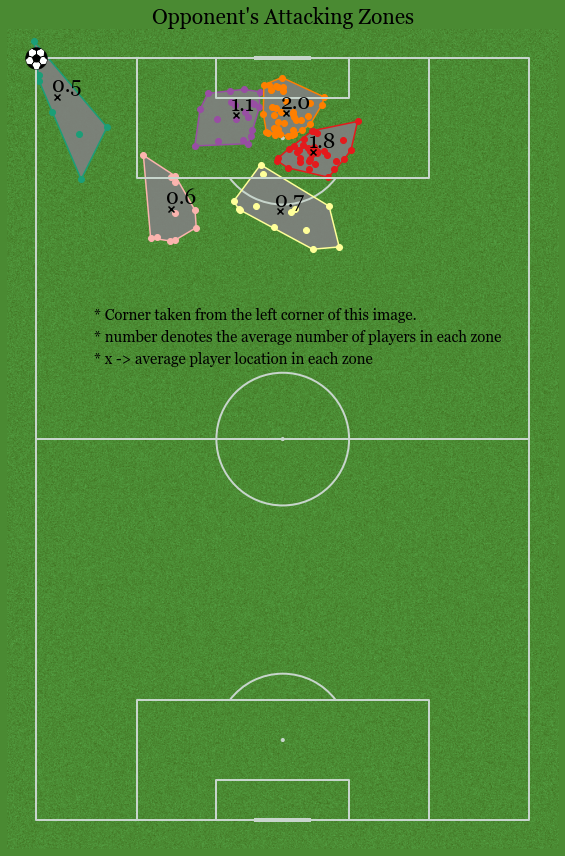

In [23]:
#All x,y coordinates of opposition players while they attack their set pieces in one list
list_opp_all_x_dc = unzip_list_of_lists(opp_all_x_dc)
list_opp_all_y_dc = unzip_list_of_lists(opp_all_y_dc)

avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_dc))

coords = np.column_stack((list_opp_all_x_dc, list_opp_all_y_dc))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Attacking Zones")

(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Defensive Zones (GK removed)"}>)

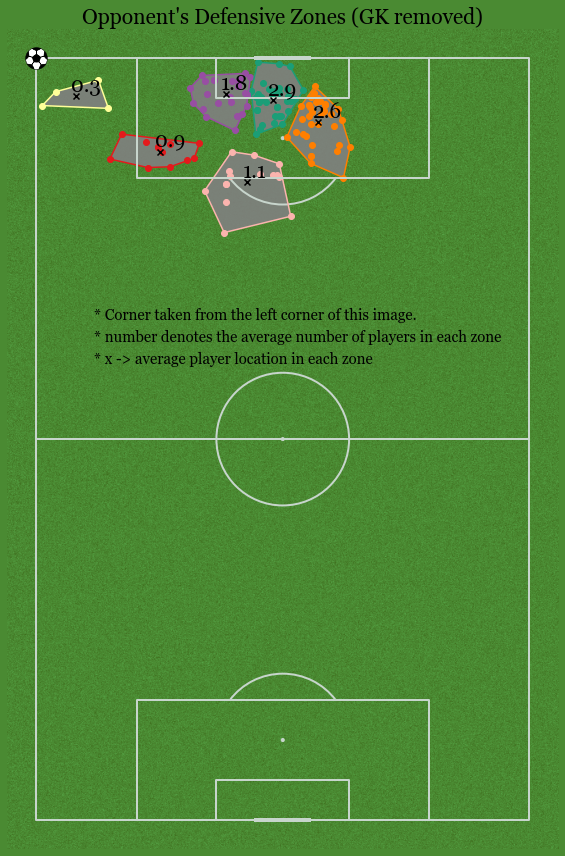

In [24]:
#All x,y coordinates of opposition players while they attack their set pieces in one list
list_opp_all_x_ac = unzip_list_of_lists(opp_all_x_ac)
list_opp_all_y_ac = unzip_list_of_lists(opp_all_y_ac)

avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_ac))

coords = np.column_stack((list_opp_all_x_ac, list_opp_all_y_ac))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_zones(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Defensive Zones (GK removed)")

In [25]:
print("Total corners taken against opposition: ", total_corners_conceded)
print("Corner takers against opposition: ", self_corner_takers)
print("Directions for corner takers against opposition: ", self_corner_directions)

print("Corners conceded by the opponent", defensive_corner_counter)


Total corners taken against opposition:  15
Corner takers against opposition:  {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}
Directions for corner takers against opposition:  {'from_left': {'Kwadwo Asamoah': 1, 'Toni Kroos': 1, 'Kevin de Bruyne': 1}, 'from_right': {}}
Corners conceded by the opponent {'from_left': 6, 'from_right': 9}


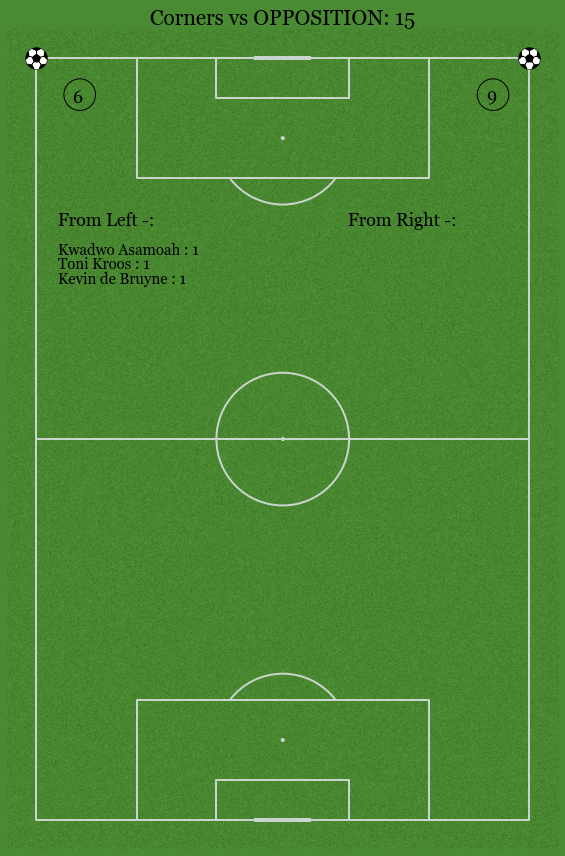

In [26]:

pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
        pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))

fig.set_facecolor('#4a8a32')

plt.title("Corners vs OPPOSITION: " + str(total_corners_conceded), **hfont,color="black",size=21)


#left side
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(62, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(63,99,str(defensive_corner_counter['from_left']),color='black',size =18, **hfont)

#right side
pitch.scatter(105, 0,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(5, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(6,99,str(defensive_corner_counter['from_right']),color='black',size =18, **hfont)



plt.text(65,82,"From Left -: ",color='black',size =18, **hfont)

left_side_takers = list(self_corner_directions['from_left'].keys())
for i in range(len(left_side_takers)):
        plt.text(65,78 - 2 * i,left_side_takers[i] + " : " + str(self_corner_directions['from_left'][left_side_takers[i]]),color='black',size =15, **hfont)




plt.text(25,82,"From Right -: ",color='black',size =18, **hfont)

right_side_takers = list(self_corner_directions['from_right'].keys())
for i in range(len(right_side_takers)):
        plt.text(25,78 - 2 * i,right_side_takers[i] + " : " + str(right_side_takers['from_right'][right_side_takers[i]]),color='black',size =15, **hfont)



In [27]:

print("Total corners taken by the opposition: ", total_corners_taken)
print("Opposition corner takers: ",opposition_corner_takers)
print("Directions for opposition corner: ", opposition_corner_directions)


print("Corners taken by the opponent: ", attacking_corner_counter)

Total corners taken by the opposition:  21
Opposition corner takers:  {'Ferland Mendy': 1}
Directions for opposition corner:  {'from_left': {'Ferland Mendy': 1}, 'from_right': {}}
Corners taken by the opponent:  {'from_left': 14, 'from_right': 7}


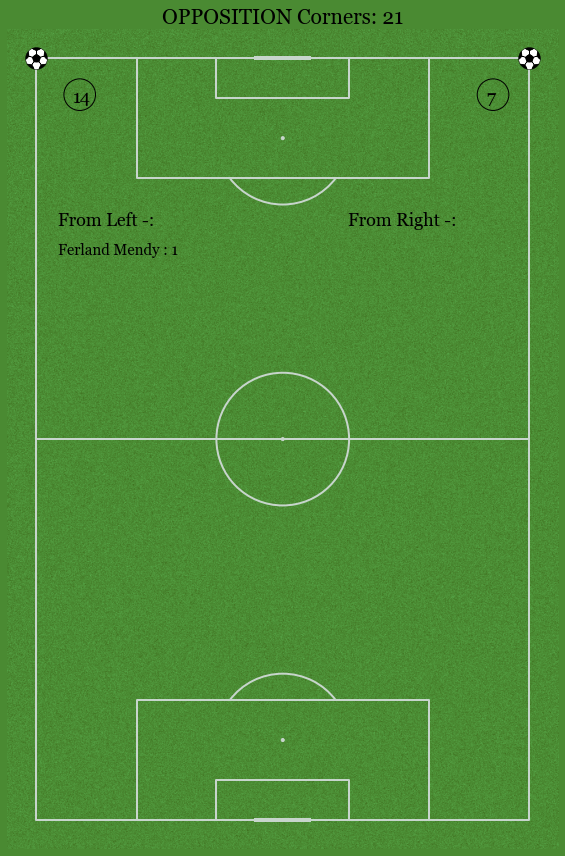

In [28]:

pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
        pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

fig, ax = pitch.draw(figsize=(14, 12))

fig.set_facecolor('#4a8a32')

plt.title("OPPOSITION Corners: " + str(total_corners_taken), **hfont,color="black",size=21)


#left side
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(62, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(63,99,str(attacking_corner_counter['from_left']),color='black',size =18, **hfont)

#right side
pitch.scatter(105, 0,c='white',marker="football",ax=ax,zorder=3,s=500)
plt.scatter(5, 100,marker="o",zorder=3,s=1000, facecolors='none', edgecolors='black')
plt.text(6,99,str(attacking_corner_counter['from_right']),color='black',size =18, **hfont)



plt.text(65,82,"From Left -: ",color='black',size =18, **hfont)

left_side_takers = list(opposition_corner_directions['from_left'].keys())
for i in range(len(left_side_takers)):
        plt.text(65,78 - 2 * i,left_side_takers[i] + " : " + str(opposition_corner_directions['from_left'][left_side_takers[i]]),color='black',size =15, **hfont)




plt.text(25,82,"From Right -: ",color='black',size =18, **hfont)

right_side_takers = list(opposition_corner_directions['from_right'].keys())
for i in range(len(right_side_takers)):
        plt.text(25,78 - 2 * i,right_side_takers[i] + " : " + str(right_side_takers['from_right'][right_side_takers[i]]),color='black',size =15, **hfont)



In [29]:
#for vertical pitch
def plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, title, velocity_coords = None, markers = None):
        
    # KMeans algorithm 
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=60).fit(coords)

    centers = np.array(kmeans_model.cluster_centers_)

    pitch = VerticalPitch(pitch_color='grass',pitch_type='custom',  
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc')

    fig, ax = pitch.draw(figsize=(14, 12))

    fig.set_facecolor('#4a8a32')

    clustered_arrays = separate_points_by_label(coords, kmeans_model.labels_)

    if type(velocity_coords) == np.ndarray:
        clustered_velocity_arrays = separate_points_by_label(velocity_coords, kmeans_model.labels_)

        for clusters in range(len(clustered_velocity_arrays)):
            avg_vx = np.mean(clustered_velocity_arrays[clusters][:,0])
            avg_vy = np.mean(clustered_velocity_arrays[clusters][:,1])

            ax.quiver(centers[clusters][1], 105 - centers[clusters][0], avg_vy, avg_vx, color="red", scale_units='inches', scale=1.5,width=0.002,headlength=5,headwidth=8)


    pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)

    plt.scatter(centers[:,1], 105 - centers[:,0], marker="o", color='black', zorder=3)

    plt.title(title, **hfont,color="black",size=21)
    
    return fig, ax



(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Defensive set up (GK removed)"}>)

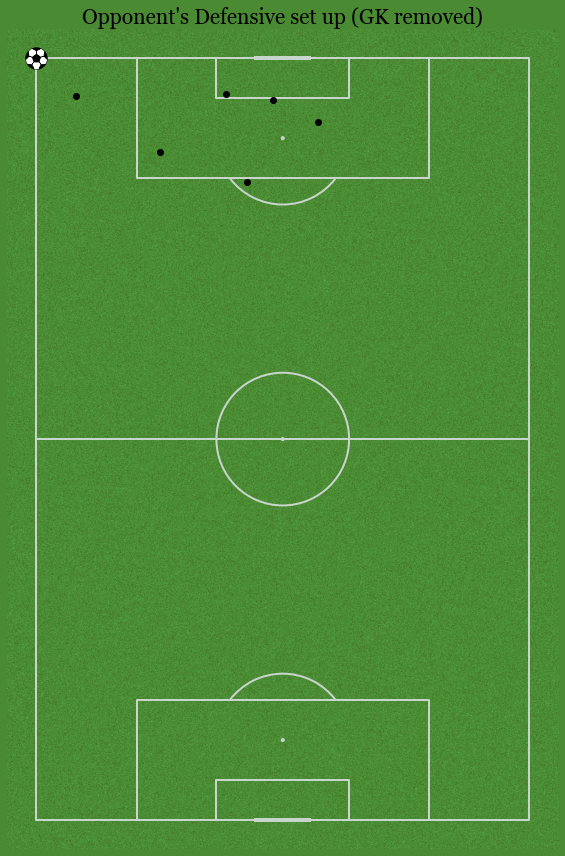

In [30]:
#All x,y coordinates of opposition players while they attack their set pieces in one list
list_opp_all_x_ac = unzip_list_of_lists(opp_all_x_ac)
list_opp_all_y_ac = unzip_list_of_lists(opp_all_y_ac)


list_opp_all_vx_ac = unzip_list_of_lists(opp_all_vx_ac)
list_opp_all_vy_ac = unzip_list_of_lists(opp_all_vy_ac)


avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_ac))

coords = np.column_stack((list_opp_all_x_ac, list_opp_all_y_ac))

coords_velocity = np.column_stack((list_opp_all_vx_ac, list_opp_all_vy_ac))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Defensive set up (GK removed)")

(<Figure size 1008x864 with 1 Axes>,
 <AxesSubplot:title={'center':"Opponent's Offensive set up"}>)

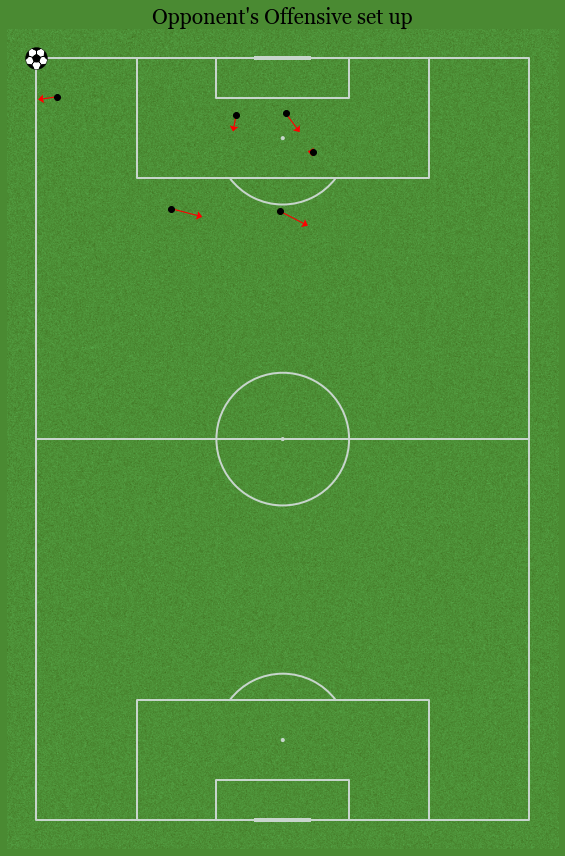

In [31]:
#All x,y coordinates of opposition players while they attack their set pieces in one list
list_opp_all_x_dc = unzip_list_of_lists(opp_all_x_dc)
list_opp_all_y_dc = unzip_list_of_lists(opp_all_y_dc)


list_opp_all_vx_dc = unzip_list_of_lists(opp_all_vx_dc)
list_opp_all_vy_dc = unzip_list_of_lists(opp_all_vy_dc)


avg_no_of_player_in_frame = np.mean(find_lengths(opp_all_x_dc))

coords = np.column_stack((list_opp_all_x_dc, list_opp_all_y_dc))

coords_velocity = np.column_stack((list_opp_all_vx_dc, list_opp_all_vy_dc))

colors = ['#e41a1c', '#1b9e77', '#984ea3', '#ff7f00', '#fbb4ae', "#ffff99"]

num_clusters = 6

plot_mean_position_and_velcocity(coords, num_clusters, colors, avg_no_of_player_in_frame, "Opponent's Offensive set up", velocity_coords = coords_velocity)